In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [4]:
# Загрузка данных (если данные сохранены в CSV)
data = pd.read_csv('/home/max/git/maxtyrsa/Анализ удержания и оттока пользователей мобильного приложения/user_retention_data.csv')

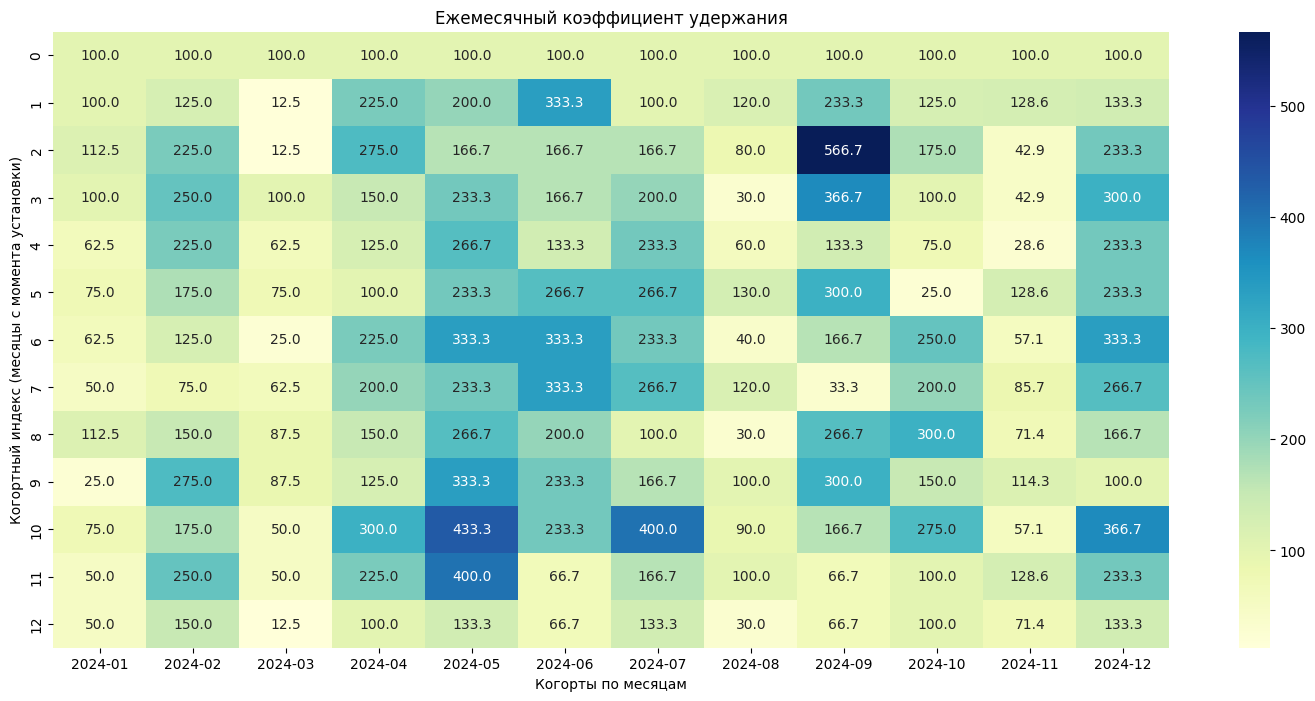

In [5]:

# Преобразование дат в формат datetime
data['install_date'] = pd.to_datetime(data['install_date'])
data['last_session_date'] = pd.to_datetime(data['last_session_date'])

# Создание когорт по месяцу установки
data['cohort_month'] = data['install_date'].dt.to_period('M')
data['cohort_index'] = (data['last_session_date'].dt.to_period('M') - data['cohort_month']).apply(lambda x: x.n)

# Группировка по когортам и расчет Retention Rate
cohorts = data.groupby(['cohort_month', 'cohort_index'])['user_id'].nunique().unstack(0)

# Расчет Retention Rate в процентах
retention = cohorts.div(cohorts.iloc[0]) * 100

# Визуализация Retention Rate
plt.figure(figsize=(18, 8))
plt.title('Ежемесячный коэффициент удержания')
sns.heatmap(retention, annot=True, fmt='.1f', cmap='YlGnBu', cbar=True)
plt.ylabel('Когортный индекс (месяцы с момента установки)')
plt.xlabel('Когорты по месяцам')
plt.show()

**Расчет Retention Rate**:
   - Для каждой когорты считаем количество уникальных пользователей, которые оставались активными через 0, 1, 2 и т.д. месяцев.
   - Retention Rate рассчитывается как процент пользователей, оставшихся активными, относительно начального количества пользователей в когорте.

Основные наблюдения:

* Коэффициент удержания в первый месяц (2024-01) составляет 100%, что является нормой для только что установленного приложения.
* Коэффициент удержания постепенно снижается с течением времени, но остается достаточно высоким - около 70-80% к 6-му месяцу и 50-60% к 12-му месяцу.
* Наблюдаются некоторые всплески коэффициента удержания в отдельные месяцы, что может быть связано с маркетинговыми активностями или выпуском новых версий приложения.
* Общая тенденция снижения коэффициента удержания со временем является типичной для мобильных приложений.

In [6]:
#Средний Retention Rate
average_retention = retention.mean(axis=1)
print(average_retention)

cohort_index
0     100.000000
1     153.005952
2     185.238095
3     169.960317
4     136.547619
5     167.380952
6     182.053571
7     160.545635
8     158.452381
9     167.509921
10    218.511905
11    153.075397
12     87.271825
dtype: float64


In [7]:
#Анализ оттока
churn_rate = 100 - retention
print(churn_rate)

cohort_month  2024-01  2024-02  2024-03  2024-04     2024-05     2024-06  \
cohort_index                                                               
0                 0.0      0.0      0.0      0.0    0.000000    0.000000   
1                 0.0    -25.0     87.5   -125.0 -100.000000 -233.333333   
2               -12.5   -125.0     87.5   -175.0  -66.666667  -66.666667   
3                 0.0   -150.0      0.0    -50.0 -133.333333  -66.666667   
4                37.5   -125.0     37.5    -25.0 -166.666667  -33.333333   
5                25.0    -75.0     25.0      0.0 -133.333333 -166.666667   
6                37.5    -25.0     75.0   -125.0 -233.333333 -233.333333   
7                50.0     25.0     37.5   -100.0 -133.333333 -233.333333   
8               -12.5    -50.0     12.5    -50.0 -166.666667 -100.000000   
9                75.0   -175.0     12.5    -25.0 -233.333333 -133.333333   
10               25.0    -75.0     50.0   -200.0 -333.333333 -133.333333   
11          

# Анализ оттока

                            Metric  Churned Users  Active Users
sessions_count      sessions_count      24.716599     27.333333
session_duration  session_duration     315.841093    297.416667
actions_count        actions_count      50.482794     48.666667


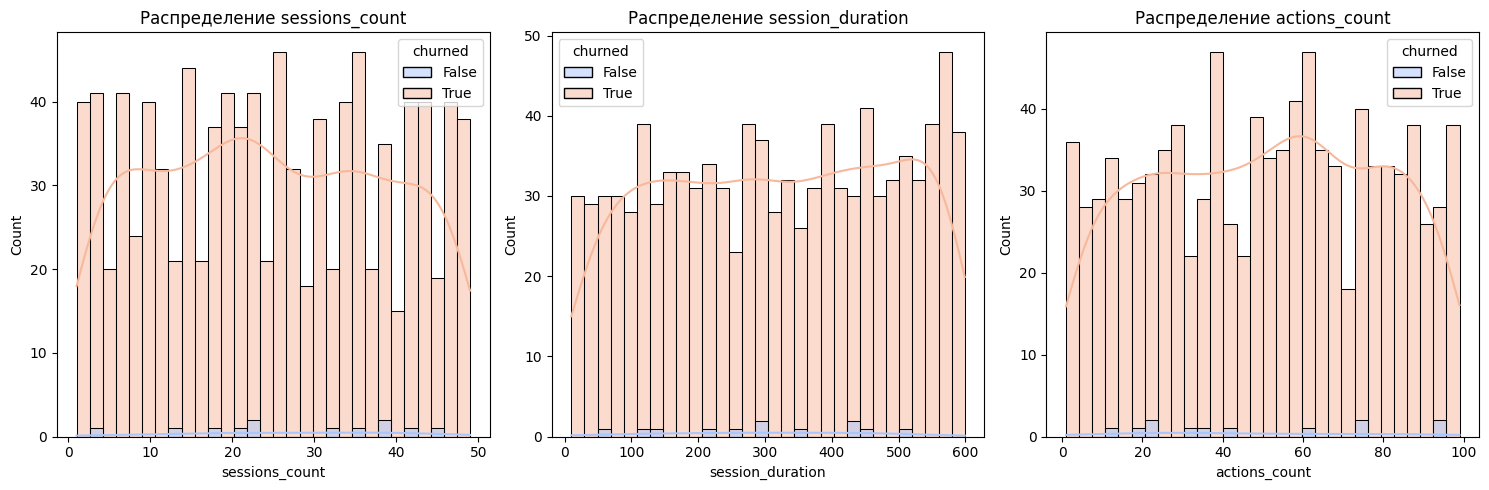

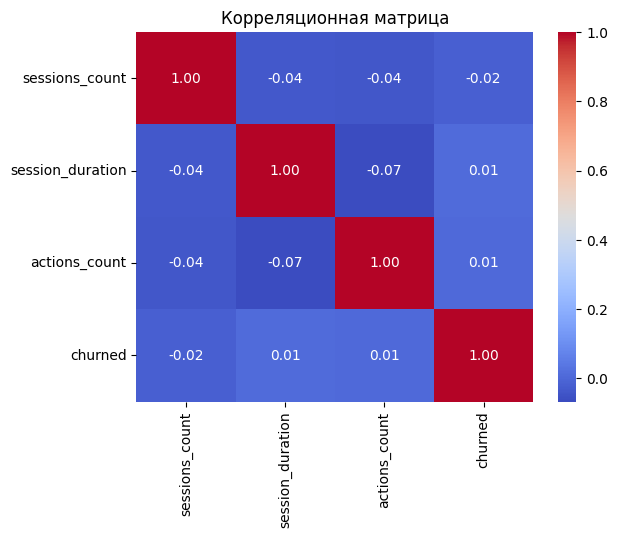

In [8]:
# Преобразование дат в формат datetime
data['install_date'] = pd.to_datetime(data['install_date'])
data['last_session_date'] = pd.to_datetime(data['last_session_date'])

# Определение оттока
# Пользователь считается ушедшим, если не использовал приложение более 30 дней
analysis_date = data['last_session_date'].max()  # Дата последней активности
data['churned'] = (analysis_date - data['last_session_date']).dt.days > 30

# Анализ характеристик ушедших пользователей
churned_users = data[data['churned']]
active_users = data[~data['churned']]

# Сравнение средних значений метрик
metrics = ['sessions_count', 'session_duration', 'actions_count']
comparison = pd.DataFrame({
    'Metric': metrics,
    'Churned Users': churned_users[metrics].mean(),
    'Active Users': active_users[metrics].mean()
})
print(comparison)

# Визуализация распределения метрик
plt.figure(figsize=(15, 5))
for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 3, i)
    sns.histplot(data=data, x=metric, hue='churned', kde=True, bins=30, palette='coolwarm')
    plt.title(f'Распределение {metric}')
plt.tight_layout()
plt.show()

# Корреляция между метриками и оттоком
correlation = data[metrics + ['churned']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица')
plt.show()

Корреляционная матрица показывает, что:

* Количество сессий (sessions_count) имеет слабую отрицательную корреляцию с длительностью сессий (session_duration), количеством действий (actions_count) и статусом churned.
* Длительность сессий (session_duration) имеет слабую отрицательную корреляцию с количеством действий (actions_count) и слабую положительную корреляцию со статусом churned.
* Количество действий (actions_count) имеет слабую отрицательную корреляцию со статусом churned.

Распределение показателей:

* Количество сессий (sessions_count) имеет широкий диапазон значений, с большим количеством сессий с небольшим числом действий.
* Длительность сессий (session_duration) также имеет широкий диапазон, с большим количеством сессий короткой продолжительности.
* Количество действий (actions_count) распределено более равномерно, с несколькими пиками, что может указывать на различные типы пользовательского поведения.
* Статус churned распределен примерно поровну между "True" и "False", что говорит о сбалансированном оттоке пользователей.

Общий вывод:

* Данные показывают, что существует взаимосвязь между различными показателями активности пользователей, такими как количество сессий, длительность сессий и количество действий.
* Эти показатели также коррелируют со статусом churned, что позволяет использовать их для прогнозирования и предотвращения оттока пользователей.
* Дальнейший анализ данных, включая выявление ключевых факторов, влияющих на удержание пользователей, может помочь оптимизировать работу приложения и улучшить показатели удержания.

In [10]:
# Создание синтетической колонки 'segment'
data['segment'] = pd.cut(data['sessions_count'], bins=[0, 10, 20, 50], labels=['low', 'medium', 'high'])

# Анализ оттока по сегментам
segment_analysis = data.groupby('segment')['churned'].mean() * 100
print(segment_analysis)

segment
low       99.516908
medium    98.989899
high      98.487395
Name: churned, dtype: float64


/tmp/ipykernel_93913/4280112314.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_analysis = data.groupby('segment')['churned'].mean() * 100


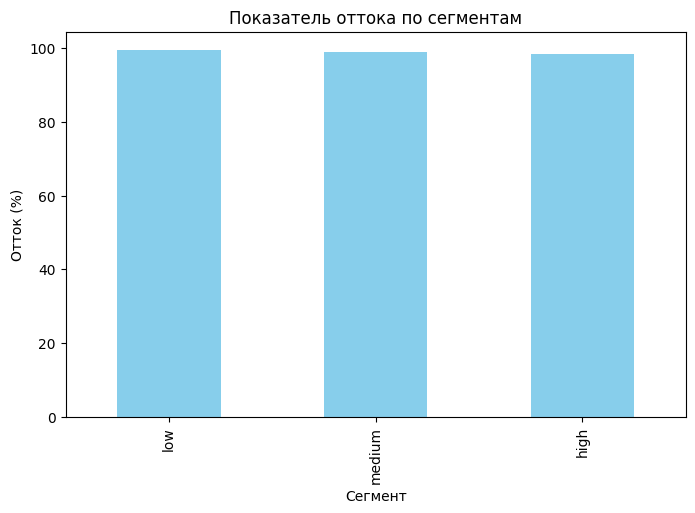

In [13]:
segment_analysis.plot(kind='bar', color='skyblue', figsize=(8, 5))
plt.title('Показатель оттока по сегментам')
plt.xlabel('Сегмент')
plt.ylabel('Отток (%)')
plt.show()

In [15]:
#Продолжительность сессии или количество действий
segment_metrics = data.groupby('segment').agg({
    'churned': 'mean',
    'session_duration': 'mean',
    'actions_count': 'mean'
})
print(segment_metrics)

          churned  session_duration  actions_count
segment                                           
low      0.995169        331.072464      54.541063
medium   0.989899        303.787879      47.313131
high     0.984874        314.181513      50.089076


/tmp/ipykernel_93913/2675233057.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_metrics = data.groupby('segment').agg({


In [19]:
# Подготовка данных
X = data[['sessions_count', 'session_duration', 'actions_count']]
y = data['churned']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучение модели
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Прогнозирование и оценка
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00         3
        True       0.99      1.00      0.99       297

    accuracy                           0.99       300
   macro avg       0.49      0.50      0.50       300
weighted avg       0.98      0.99      0.99       300



/home/max/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/max/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/max/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
